# Code describe the line of reasoning we need to show for all the cases

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score

# Load data

In [98]:
B = pd.read_parquet('./data/B_HKML.parquet')

In [99]:
B = B[B['date'] < '2022-05-01']

In [100]:
X_df = pd.read_parquet('./data/X_HKML.parquet')

In [101]:
X_df.reset_index(drop=True, inplace=True)

In [102]:
X_df = X_df[X_df['date'] < '2022-05-01']

In [103]:
y = pd.read_parquet('./data/Y_HKML.parquet')

In [104]:
y = y.iloc[X_df.index]

In [105]:
X = X_df.drop('date', axis=1).to_numpy()

In [106]:
y = y.to_numpy().ravel()

# Train-test split

In [107]:
moons = X_df.date.unique()

In [108]:
moons.shape[0]

307

In [61]:
moon_train = moons[230]
idx_train = X_df[X_df.date < moon_train].index.to_numpy()
idx_train

array([     0,      1,      2, ..., 232749, 232750, 232751])

In [62]:
moon_purge = moons[260]
idx_test = X_df[X_df.date >= moon_purge].index.to_numpy()
idx_test

array([263296, 263297, 263298, ..., 310701, 310702, 310703])

In [63]:
X_train = X[idx_train]
y_train = y[idx_train]

In [64]:
idx_test

array([263296, 263297, 263298, ..., 310701, 310702, 310703])

In [65]:
X_test = X[idx_test]
y_test = y[idx_test]

In [66]:
y_test.shape

(47408,)

# Train model and predict

In [67]:
# As this notebook shows a simple linear model, there is no need to introduce validation data, i.e. 
# the training is deterministic and only one epoch is necessary to perform it.
# Nevertheless, this section should train such that the validation loss is minimized.

In [68]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [69]:
regr.fit(X_train, y_train)

LinearRegression()

In [70]:
y_hat = regr.predict(X_test)

# Scatter plot to show linear relation between Y and y_hat

In [71]:
from scipy.stats import linregress

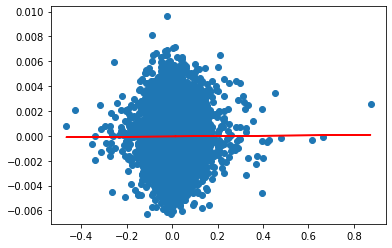

In [72]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_hat)
plt.scatter(y_test, y_hat)
plt.plot(y_test, slope * y_test + intercept,'r')
plt.show()

In [73]:
y_hat_df = pd.DataFrame()
y_hat_df['date'] = X_df[X_df['date'] >= moon_purge].date
y_hat_df['y_hat'] = y_hat
y_hat_df['Y'] = y_test

In [74]:
y_hat_df

,date,y_hat,Y
263296,2021-06-09,-0.002599,0.014321
263297,2021-06-09,0.000244,0.007357
263298,2021-06-09,-0.001522,0.046698
263299,2021-06-09,0.000224,0.017977
263300,2021-06-09,-0.003396,-0.011408
...,...,...,...
310699,2022-04-27,0.001564,0.020271
310700,2022-04-27,0.002171,-0.023498
310701,2022-04-27,-0.000778,0.007559
310702,2022-04-27,-0.000361,-0.006418


# Spearman

In [75]:
def spear(x):
    return x.corr(method='spearman').iloc[0, 1]

In [76]:
spearman = y_hat_df.groupby("date").apply(lambda x: spear(x))

/tmp/ipykernel_15990/710519440.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return x.corr(method='spearman').iloc[0, 1]


In [77]:
spearman.mean()

0.002715163962991602

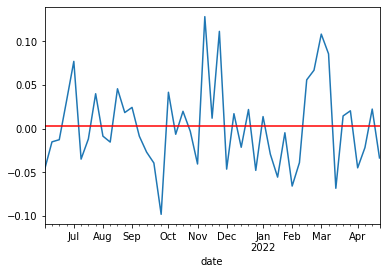

In [78]:
spearman.plot()
plt.axhline(y=spearman.mean(), color='r', linestyle='-')
plt.show()

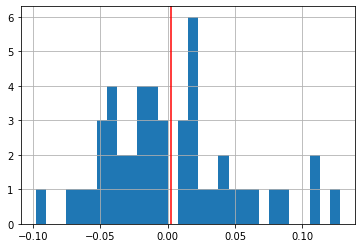

In [79]:
spearman.hist(bins=30)
plt.axvline(x=spearman.mean(), color='r', linestyle='-')

# MSE

In [80]:
mse = y_hat_df.groupby('date').apply(lambda x: mean_squared_error(x.y_hat, x.Y))

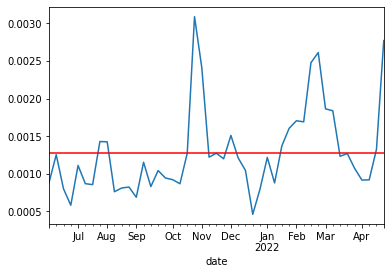

In [81]:
mse.plot()
plt.axhline(y=mse.mean(), color='r', linestyle='-')
plt.show()

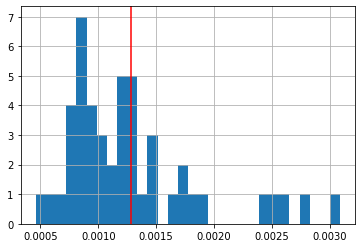

In [82]:
mse.hist(bins=30)
plt.axvline(x=mse.mean(), color='r', linestyle='-')

# Orthogonalize output and show same results.

In [83]:
B = B.iloc[idx_test, :]

In [84]:
y_hat_date = y_hat_df[['date', 'y_hat']] 

In [85]:
import sys
sys.path.insert(1, "../feature-engineering/src")
from class_ import Data

In [86]:
data = Data(f_matrix=y_hat_date, b_matrix=B)

In [87]:
data.orthogonalize()

  0%|          | 0/47 [00:00<?, ?it/s]

0

In [88]:
data.f_matrix

,date,y_hat
263296,2021-06-09,-0.002556
263297,2021-06-09,0.000287
263298,2021-06-09,-0.001480
263299,2021-06-09,0.000266
263300,2021-06-09,-0.003354
...,...,...
310699,2022-04-27,0.001606
310700,2022-04-27,0.002213
310701,2022-04-27,-0.000736
310702,2022-04-27,-0.000319


In [89]:
y_hat_df.y_hat = data.f_matrix.y_hat

In [90]:
y_hat_df

,date,y_hat,Y
263296,2021-06-09,-0.002556,0.014321
263297,2021-06-09,0.000287,0.007357
263298,2021-06-09,-0.001480,0.046698
263299,2021-06-09,0.000266,0.017977
263300,2021-06-09,-0.003354,-0.011408
...,...,...,...
310699,2022-04-27,0.001606,0.020271
310700,2022-04-27,0.002213,-0.023498
310701,2022-04-27,-0.000736,0.007559
310702,2022-04-27,-0.000319,-0.006418


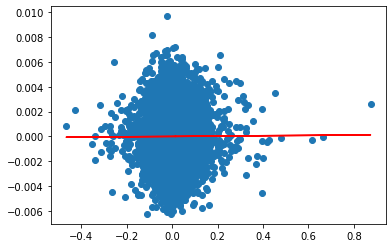

In [91]:
slope, intercept, r_value, p_value, std_err = linregress(y_hat_df.Y,y_hat_df.y_hat)
plt.scatter(y_hat_df.Y, y_hat_df.y_hat)
plt.plot(y_hat_df.Y, slope * y_hat_df.Y + intercept,'r')
plt.show()

In [92]:
spearman.mean()

0.002715163962991602

/tmp/ipykernel_15990/710519440.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return x.corr(method='spearman').iloc[0, 1]


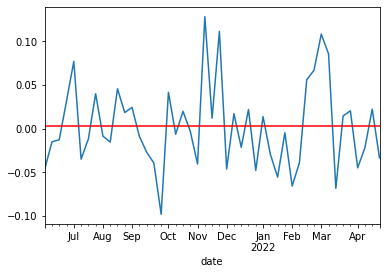

In [93]:
spearman = y_hat_df.groupby("date").apply(lambda x: spear(x))
spearman.plot()
plt.axhline(y=spearman.mean(), color='r', linestyle='-')
plt.show()

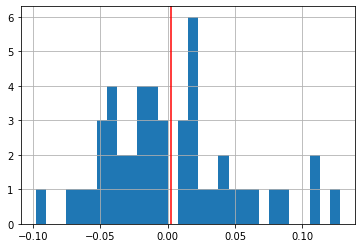

In [94]:
spearman.hist(bins=30)
plt.axvline(x=spearman.mean(), color='r', linestyle='-')

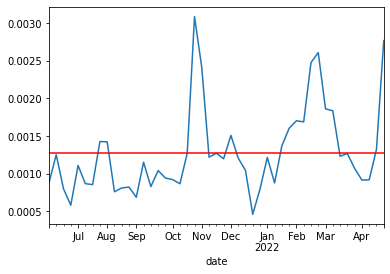

In [95]:
mse = y_hat_df.groupby('date').apply(lambda x: mean_squared_error(x.y_hat, x.Y))
mse.plot()
plt.axhline(y=mse.mean(), color='r', linestyle='-')
plt.show()

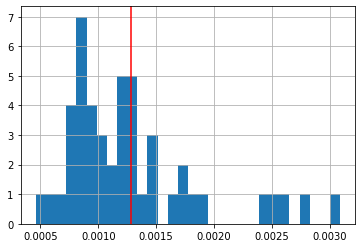

In [96]:
mse.hist(bins=30)
plt.axvline(x=mse.mean(), color='r', linestyle='-')